In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib


import pickle
import scipy.optimize as optim
import logging

logging.getLogger().setLevel(logging.ERROR)
    

%matplotlib inline

plt.style.use('bmh')

WORKDIR = 'C:/Users/Paulo/Desktop/infnet-projeto-final/mit_data_science/'

input_table = WORKDIR + '/Data/Processed/nyctaxi_data_analysis_yellow.parquet'
model_file = WORKDIR + '/Data/Modeling/taxi_model.jbl'
save_data = WORKDIR + '/Data/Modeling/dev_results.jbl'

pd.plotting.register_matplotlib_converters()

target_variable = 'fare_amount'
classifier_variables = ['dropoff_latitude', 'dropoff_longitude',
       'passenger_count', 'pickup_latitude', 'pickup_longitude', 'hour_of_day',
       'day_of_week', 'day_of_year', 'year', 'eucl_distance', 'manh_distance']

# Carga dos Dados 

In [2]:
train = pd.read_parquet(input_table)

print('shape:', train.shape)
print('columns:', train.columns)

shape: (3883, 12)
columns: Index(['dropoff_latitude', 'dropoff_longitude', 'fare_amount',
       'passenger_count', 'pickup_latitude', 'pickup_longitude', 'hour_of_day',
       'day_of_week', 'day_of_year', 'year', 'eucl_distance', 'manh_distance'],
      dtype='object')


In [38]:
train

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance,estimated_fare,idTaxi
index,,,,,,,,,,,,,,
4000,40.772537,-73.952852,6.0,1,40.781080,-73.960960,23,1,182,2014,1.170192,1.852088,5.529762,4000
4001,40.766477,-73.978090,9.0,6,40.760512,-73.971795,14,1,28,2014,0.849392,1.363678,6.055681,4001
4002,40.787835,-73.955601,4.5,1,40.793633,-73.966991,9,6,208,2014,1.155824,1.911818,5.484866,4002
4003,40.759287,-73.974354,3.0,1,40.755553,-73.977370,8,1,189,2014,0.486902,0.750801,5.777875,4003
4004,40.770861,-73.865488,31.5,1,40.755373,-73.971965,14,4,339,2014,9.134312,13.566147,31.200061,4004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,40.745200,-73.994063,5.3,1,40.754433,-73.980287,13,0,213,2011,1.549905,2.559287,6.435945,7995
7996,40.726895,-74.003175,6.9,1,40.729962,-74.003908,18,4,126,2011,0.346692,0.422673,5.883169,7996
7997,40.748200,-73.984800,4.9,3,40.757900,-73.985700,15,5,281,2011,1.081591,1.179036,5.872100,7997


In [4]:
X = train.drop('fare_amount', axis = 1)

In [5]:
X.shape

(3883, 11)

In [6]:
y = train['fare_amount']

In [7]:
y.shape

(3883,)

# Treino / Teste 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_train_scaled[0]

In [8]:
from sklearn.model_selection import cross_val_score
cv = 3
scoring = 'neg_mean_squared_error'
import multiprocessing
n_jobs = multiprocessing.cpu_count() - 1

In [9]:
n_jobs

7

### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.7948486550972933

### Ridge Regression

In [11]:
from sklearn.linear_model import Ridge
model = Ridge()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.7827162024674226

### Lasso Regression

In [12]:
from sklearn.linear_model import Lasso
model = Lasso()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.011937378356693

### Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

4.554401224960701

### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

5.1565162505106485

### Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.959794565777524

### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
scores = cross_val_score(model, X, y, cv = cv,
                         scoring = scoring, n_jobs = n_jobs)
np.sqrt(-scores.mean())

3.615957854342245

## Inspecionando o melhor modelo

### Dividindo a base de dados

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size = 0.2, random_state = 24)

In [19]:
X_train.shape

(3106, 11)

In [20]:
X_train.shape

(3106, 11)

In [21]:
X_test.shape

(777, 11)

### Treinamento do modelo

In [22]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


GradientBoostingRegressor()

### Inspecionando o modelo

In [23]:
features_importances = model.feature_importances_
features_importances

array([1.28673863e-02, 1.61397241e-02, 6.20627046e-05, 3.31883207e-03,
       7.56623477e-03, 9.34960634e-03, 2.17939446e-03, 5.98957087e-03,
       1.53389234e-02, 8.64780730e-01, 6.24075348e-02])

In [24]:
argsort = np.argsort(features_importances)
argsort

array([ 2,  6,  3,  7,  4,  5,  0,  8,  1, 10,  9], dtype=int64)

In [25]:
features_importances_sorted = features_importances[argsort]
features_importances_sorted

array([6.20627046e-05, 2.17939446e-03, 3.31883207e-03, 5.98957087e-03,
       7.56623477e-03, 9.34960634e-03, 1.28673863e-02, 1.53389234e-02,
       1.61397241e-02, 6.24075348e-02, 8.64780730e-01])

In [26]:
feature_names = X_train.columns
feature_names

Index(['dropoff_latitude', 'dropoff_longitude', 'passenger_count',
       'pickup_latitude', 'pickup_longitude', 'hour_of_day', 'day_of_week',
       'day_of_year', 'year', 'eucl_distance', 'manh_distance'],
      dtype='object')

In [27]:
features_sorted = feature_names[argsort]
features_sorted

Index(['passenger_count', 'day_of_week', 'pickup_latitude', 'day_of_year',
       'pickup_longitude', 'hour_of_day', 'dropoff_latitude', 'year',
       'dropoff_longitude', 'manh_distance', 'eucl_distance'],
      dtype='object')

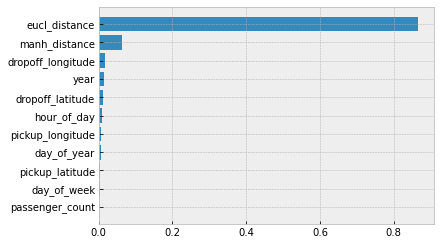

In [28]:
plt.barh(features_sorted, features_importances_sorted);

In [29]:
mse = model.train_score_[-1]
mse

6.475721739961109

In [30]:
rmse = np.sqrt(mse)
rmse

2.5447439438892685

# Previsões na base de dados de Teste

In [31]:
y_pred = model.predict(X_test)
y_pred

array([ 9.0408389 , 14.76244908,  3.72991299,  8.8047673 ,  4.97727098,
       10.02187233,  7.43209537, 49.52011631,  5.69975738,  8.13964291,
        6.38994385,  7.98580207, 18.19317781,  4.75676293, 12.9177587 ,
       13.65715413, 19.12842754, 15.09957013,  7.74002952,  5.1163873 ,
       17.25154667,  5.50557916, 47.36233885,  4.77979645, 15.62583118,
        8.91588888, 13.70897267,  8.19685848,  6.15374311,  7.80123452,
        8.78617117,  5.9904359 , 24.90065802,  6.42524598, 10.85486626,
        6.7972828 ,  5.94888468,  8.86361147, 11.39337702,  5.23484535,
       11.92419575,  9.58300281,  4.82466058, 24.99057184,  4.93180768,
        7.13753276,  9.05558693,  5.72775795, 12.10849677,  7.52812483,
       23.71750371,  4.73769076,  4.29316365,  7.41995871, 17.68923248,
       10.12784922,  8.28870688, 13.7923687 , 10.67932692, 42.80667845,
        4.77380314,  9.21027033,  8.2541667 ,  8.70412724,  4.87524061,
        7.64928042,  9.02189444, 11.5754821 , 10.43664182, 11.88

In [45]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)

In [46]:
rmse

3.429602047460873

# Exportar os resultados da Modelagem 

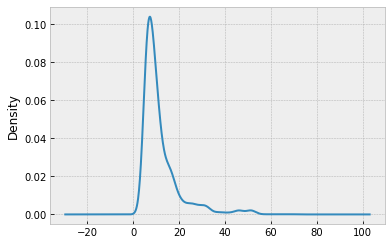

In [33]:
y_pred1 = model.predict(X)
train['estimated_fare'] = y_pred1
train['idTaxi'] = X.index.values

train.to_parquet(save_data)
train.estimated_fare.plot.kde()

In [34]:
train

,dropoff_latitude,dropoff_longitude,fare_amount,passenger_count,pickup_latitude,pickup_longitude,hour_of_day,day_of_week,day_of_year,year,eucl_distance,manh_distance,estimated_fare,idTaxi
index,,,,,,,,,,,,,,
4000,40.772537,-73.952852,6.0,1,40.781080,-73.960960,23,1,182,2014,1.170192,1.852088,5.529762,4000
4001,40.766477,-73.978090,9.0,6,40.760512,-73.971795,14,1,28,2014,0.849392,1.363678,6.055681,4001
4002,40.787835,-73.955601,4.5,1,40.793633,-73.966991,9,6,208,2014,1.155824,1.911818,5.484866,4002
4003,40.759287,-73.974354,3.0,1,40.755553,-73.977370,8,1,189,2014,0.486902,0.750801,5.777875,4003
4004,40.770861,-73.865488,31.5,1,40.755373,-73.971965,14,4,339,2014,9.134312,13.566147,31.200061,4004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,40.745200,-73.994063,5.3,1,40.754433,-73.980287,13,0,213,2011,1.549905,2.559287,6.435945,7995
7996,40.726895,-74.003175,6.9,1,40.729962,-74.003908,18,4,126,2011,0.346692,0.422673,5.883169,7996
7997,40.748200,-73.984800,4.9,3,40.757900,-73.985700,15,5,281,2011,1.081591,1.179036,5.872100,7997


joblib.dump({'model': model,
             'variables': classifier_variables},
            model_file)

In [36]:
model_file = WORKDIR + '/Data/Modeling/taxi_model.jbl'

with open(model_file, 'wb') as fid:
    pickle.dump({'model': model,
             'variables': classifier_variables}, fid)

# exportar a tabela de resultados
df_results.to_parquet(model_score_file)

filename = model_score_file.replace(".parquet","_" + df_results.date_end.max().date().strftime('%Y-%m-%d') + ".parquet") 
df_results.to_parquet(filename)


with open(model_file, 'wb') as fid:
    pickle.dump(trained_models, fid)


filename = model_file.replace(".jbl","_" + df_results.date_end.max().date().strftime('%Y-%m-%d') + ".jbl")     
with open(model_file, 'wb') as fid:
    pickle.dump(trained_models, fid)
    
    
df_results.head()